In [1]:
import numpy as np
from astropy.io import fits

In [92]:
TIC = 350842552

import lightkurve as lk
lcs = lk.search_lightcurve(f"TIC {TIC}", exptime='short', author='SPOC').download_all()

In [93]:
lcs

LightCurveCollection of 26 objects:
    0: <TessLightCurve LABEL="TIC 350842552" SECTOR=1 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 350842552" SECTOR=2 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 350842552" SECTOR=3 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 350842552" SECTOR=4 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 350842552" SECTOR=5 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 350842552" SECTOR=6 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 350842552" SECTOR=7 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="TIC 350842552" SECTOR=8 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    8: <TessLightCurve LABEL="TIC 350842552" SECTOR=9 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    9: <TessLightCurve LABEL="TIC 350842552" SECTOR=10 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    10: <TessLightCurve LABEL="TIC 350842552" SECTOR=

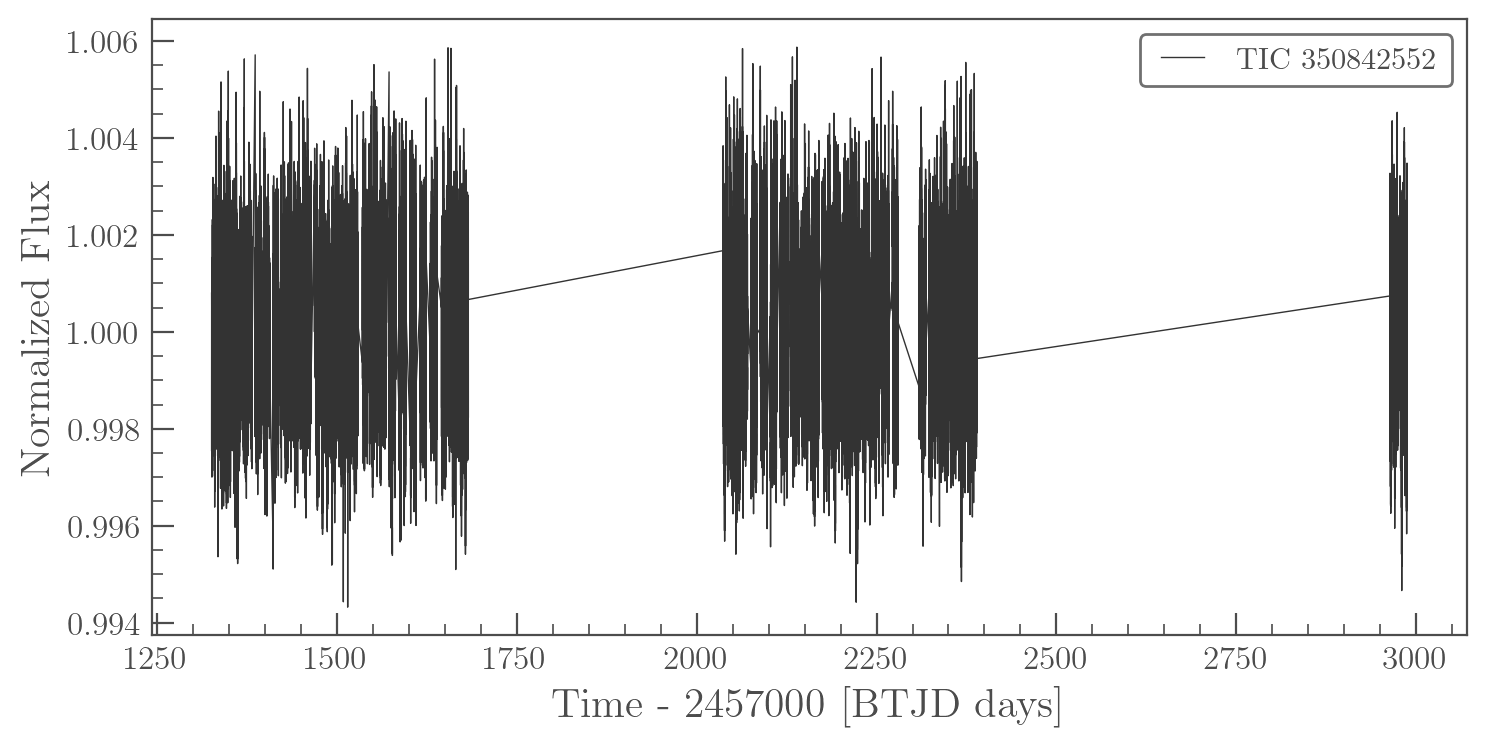

In [94]:
import matplotlib.pyplot as plt
lc = lcs.stitch().remove_outliers()
lc.plot()
plt.show()

In [249]:
from astropy import units as u
pg = lc.to_periodogram(normalization='psd', oversample_factor=1, maximum_frequency=(15 * u.uHz))

In [359]:
seis = pg.flatten().to_seismology()
# seis = pg.to_seismology()

In [360]:
seis.estimate_numax(window_width=(1 * u.uHz))

numax: 7.50 uHz (method: ACF2D)

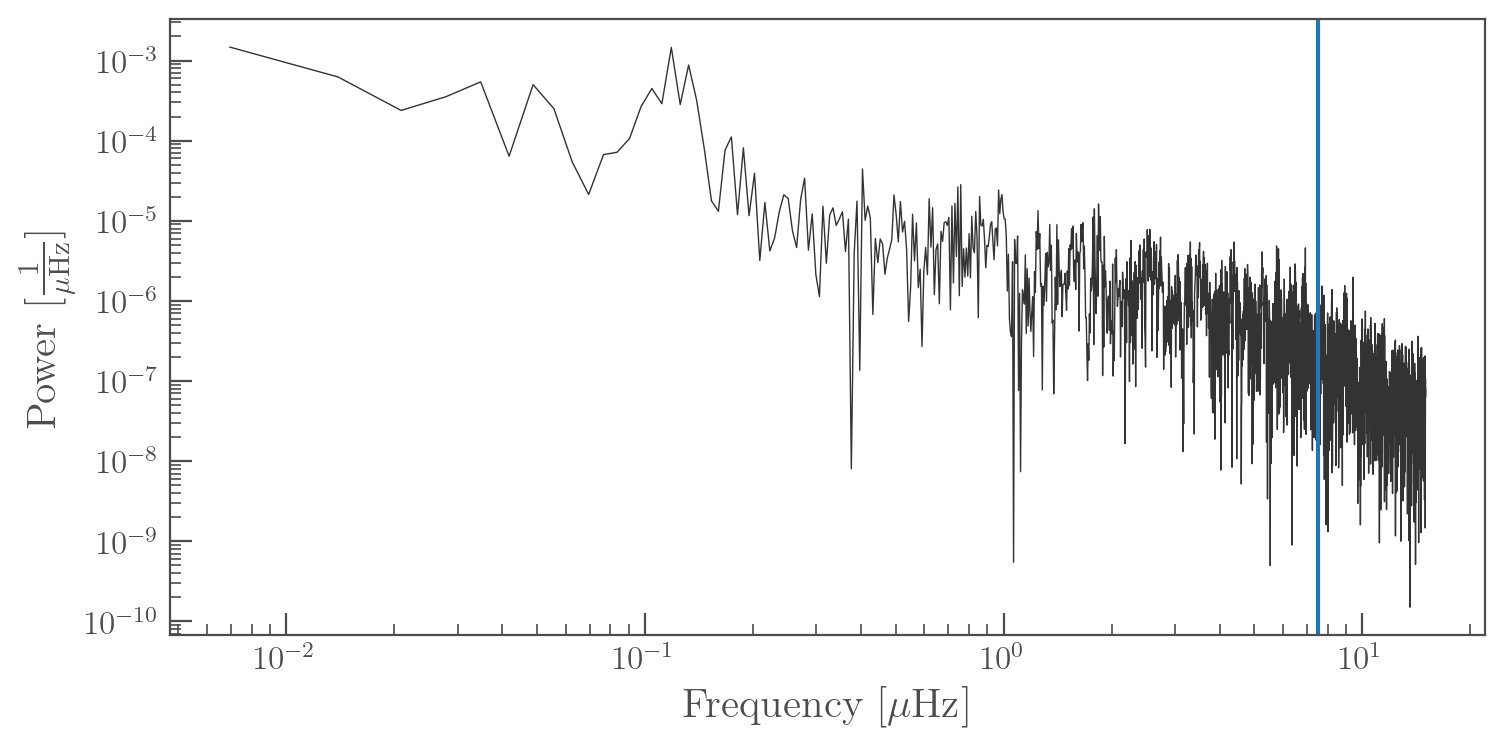

In [361]:
pg.plot()
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.axvline(seis.numax.value)
plt.show()

In [362]:
seis.estimate_deltanu()

deltanu: 1.70 uHz (method: ACF2D)

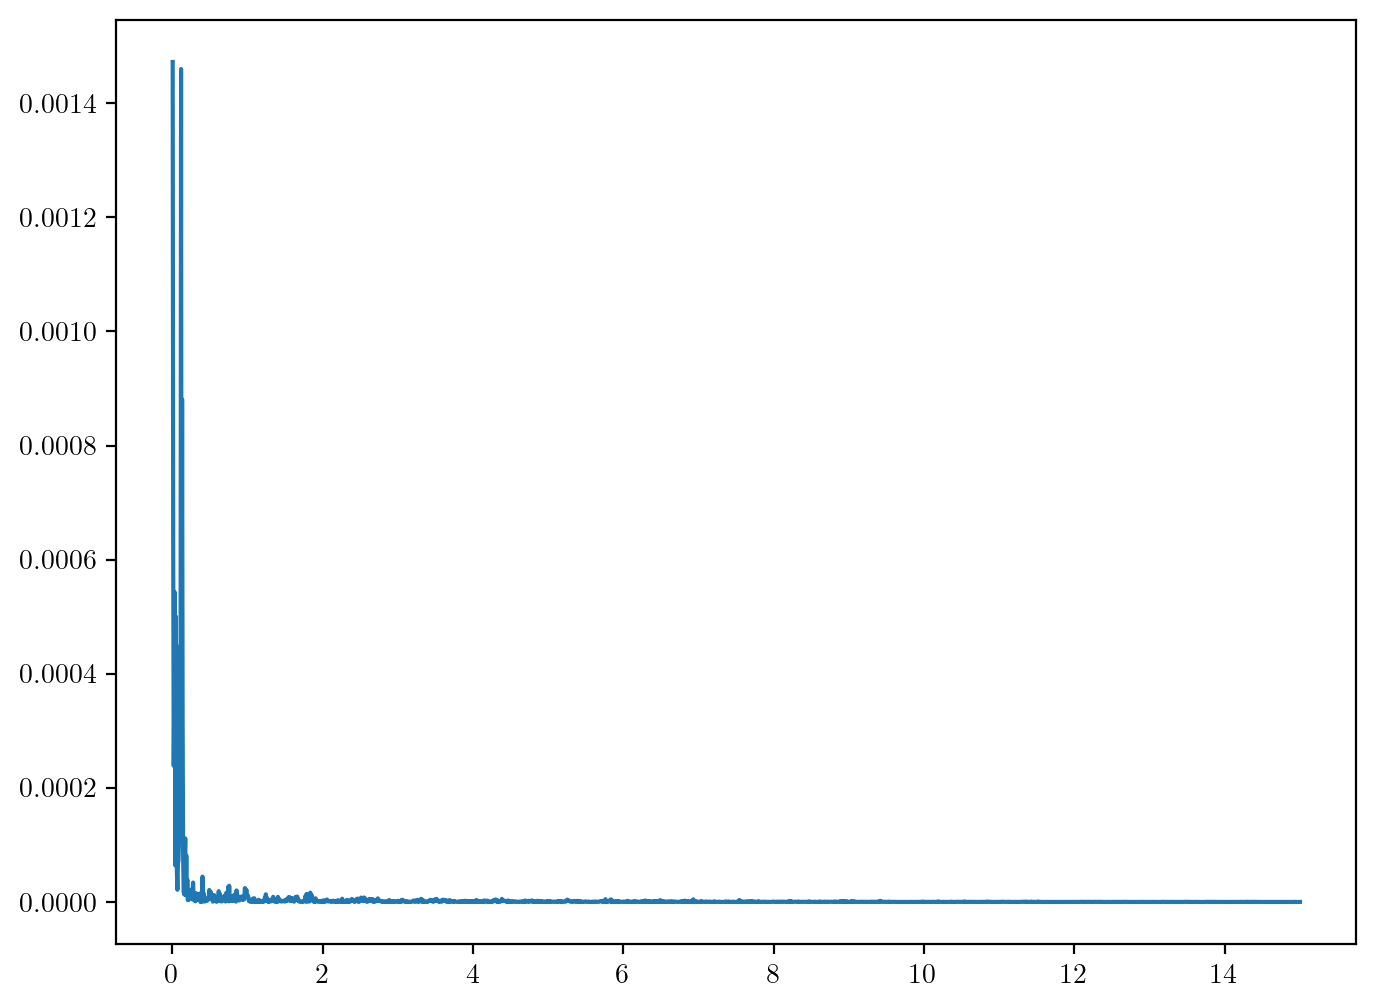

In [363]:
plt.plot(pg.frequency, pg.power)
plt.show()

In [365]:
seis.deltanu = 1.23 * u.uHz
seis.numax = 7.50 * u.uHz

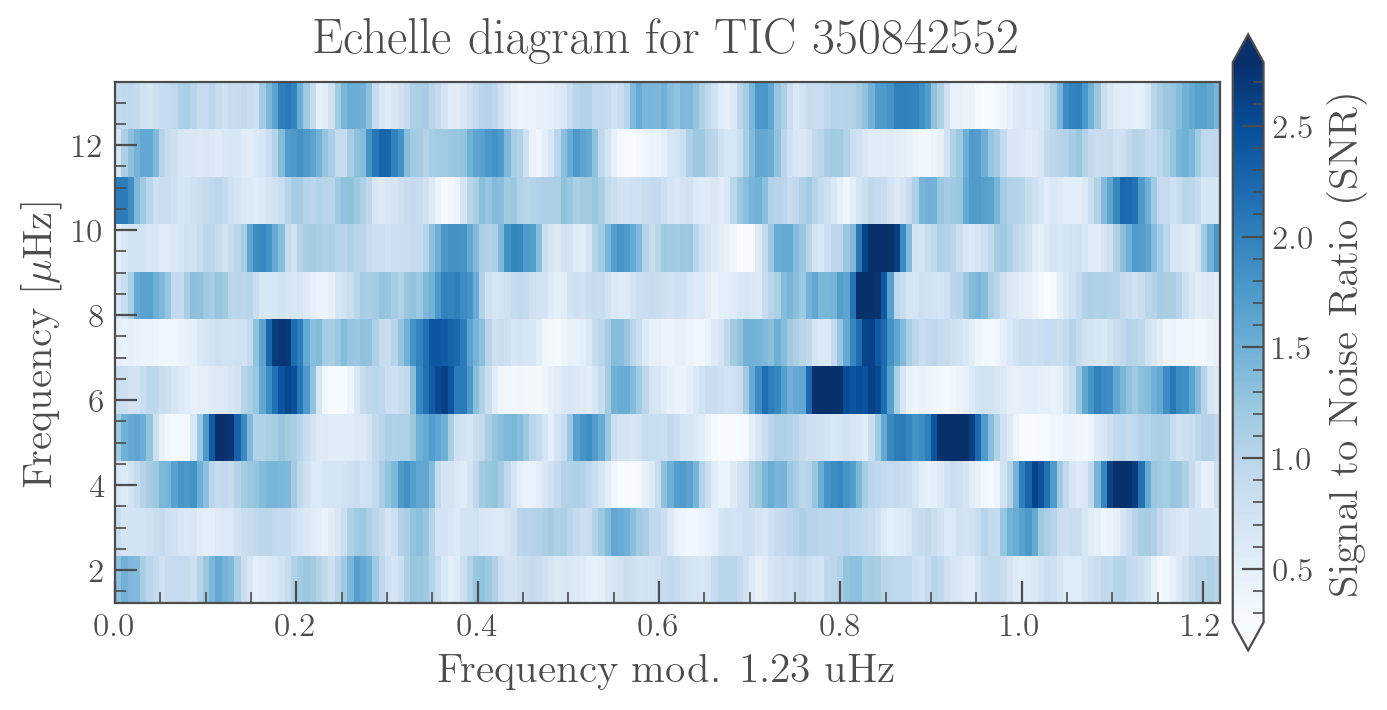

In [257]:
seis.plot_echelle(smooth_filter_width=.04)
plt.show()

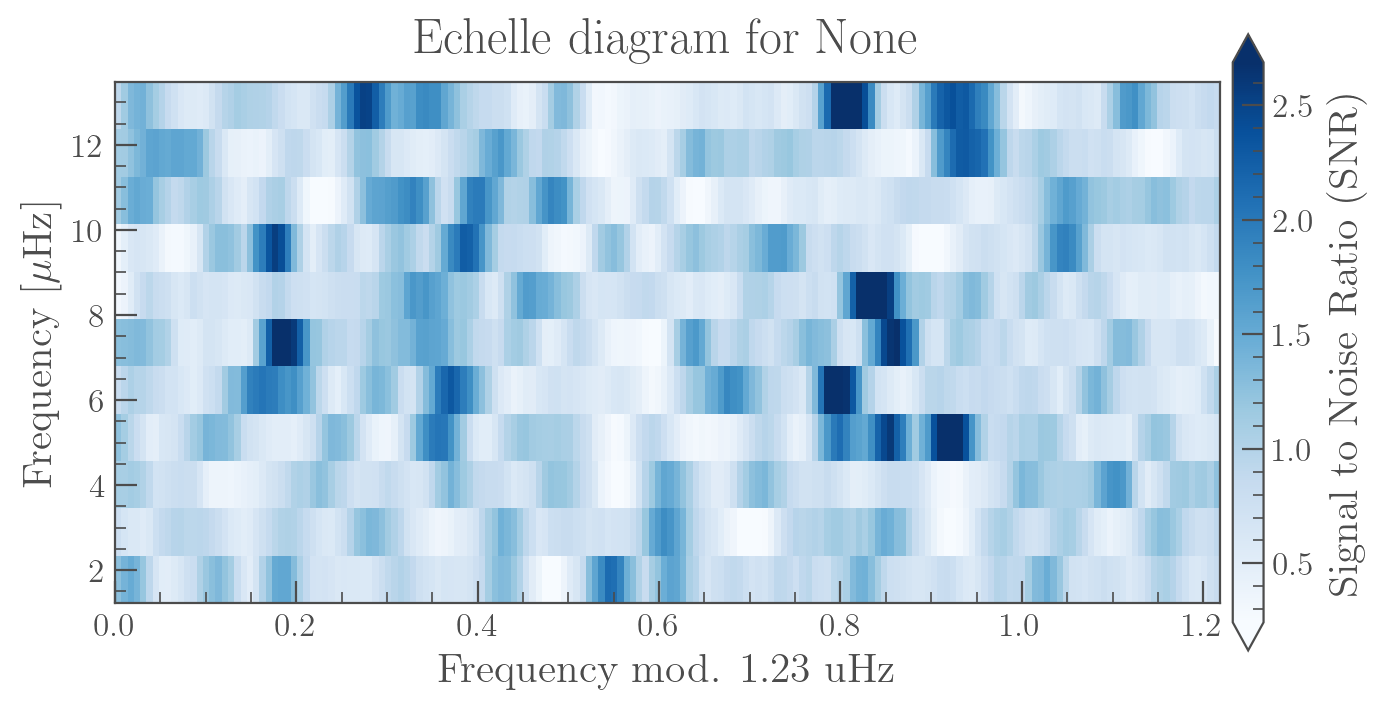

In [366]:
seis.plot_echelle(smooth_filter_width=.04)
plt.show()

In [181]:
np.save(f"TIC{TIC}", {
    'ID': TIC, 'f': pg.frequency.value,
    'p': pg.power.value,
    'Δν': seis.deltanu.value,
    'νmax': seis.numax.value,
    't': np.array(lc.time.value),
    'flux': np.array(lc.flux),
    'flux_err': np.array(lc.flux_err)
})

In [8]:
import lightkurve as lk

TIC = 278730820
tpfs = lk.search_targetpixelfile("tic 278730820").download_all()

/home/marc/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:475: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


In [141]:
tpfs

TargetPixelFileCollection of 26 objects:
    0: TessTargetPixelFile(TICID: 350842552)
    1: TessTargetPixelFile(TICID: 350842552)
    2: TessTargetPixelFile(TICID: 350842552)
    3: TessTargetPixelFile(TICID: 350842552)
    4: TessTargetPixelFile(TICID: 350842552)
    5: TessTargetPixelFile(TICID: 350842552)
    6: TessTargetPixelFile(TICID: 350842552)
    7: TessTargetPixelFile(TICID: 350842552)
    8: TessTargetPixelFile(TICID: 350842552)
    9: TessTargetPixelFile(TICID: 350842552)
    10: TessTargetPixelFile(TICID: 350842552)
    11: TessTargetPixelFile(TICID: 350842552)
    12: TessTargetPixelFile(TICID: 350842552)
    13: TessTargetPixelFile(TICID: 350842552)
    14: TessTargetPixelFile(TICID: 350842552)
    15: TessTargetPixelFile(TICID: 350842552)
    16: TessTargetPixelFile(TICID: 350842552)
    17: TessTargetPixelFile(TICID: 350842552)
    18: TessTargetPixelFile(TICID: 350842552)
    19: TessTargetPixelFile(TICID: 350842552)
    20: TessTargetPixelFile(TICID: 350842552)
   

In [103]:
%env BOKEH_ALLOW_WS_ORIGIN=localhost:47784

env: BOKEH_ALLOW_WS_ORIGIN=localhost:47784


In [186]:
tpfs[0].interact()

In [276]:
tpf_lcs = [_.to_corrector().correct() for _ in tpfs]

In [344]:
def custom_reject_outlier(lc, degree=2, sigma=5):
    t = lc.time.value
    f = lc.flux.value
    e = lc.flux_err.value
    
    x = (t - t[0]) / (t[-1] - t[0])
    s = np.nanmax(f) - np.nanmin(f)
    m = (np.nanmax(f) + np.nanmin(f))/2
    y = (f-m)/s
    e_y = e/s
    
    mask = np.ones_like(t, dtype=bool)
    while True:
        smooth = np.polyval(np.polyfit(x[mask], y[mask], degree, w=1/e_y[mask]), x[mask])
        res = y[mask] - smooth
        z = np.abs(res) / np.std(res)
        if np.all(z < sigma):
            break
        mask[mask] &= z < sigma

    return mask

In [345]:
outlier_masks = [custom_reject_outlier(_) for _ in tpf_lcs]

In [348]:
tt = [_.time.value+2457000 for _ in tpf_lcs] # convert to BJD
ff = [_.flux.value for _ in tpf_lcs]
ee = [_.flux_err.value for _ in tpf_lcs]

In [382]:
5 / np.median(np.diff(tt[0]))

3599.9688330010777

In [380]:
# Let's do stitching in this notebook instead of the ASAS-SN one.

s = 1

start = slice(None, 3600)
end = slice(-3600, None)

ff_stitched = []
ee_stitched = []

for i, (t, f, e, m) in enumerate(zip(tt, ff, ee, outlier_masks)):
    sprime = s * np.median(f[m][start]/np.polyval(np.polyfit(tt[i-1][outlier_masks[i-1]][end],
                                                             ff[i-1][outlier_masks[i-1]][end], 1,
                                                             w=1/ee[i-1][outlier_masks[i-1]][end]),
                                                  t[m][start]))
    
    if not i or t[0] - tt[i-1][-1] > 5:
        s = np.median(f[m])
    else:
        s = sprime
        
    ff_stitched.append(f / s)
    ee_stitched.append(e / s)

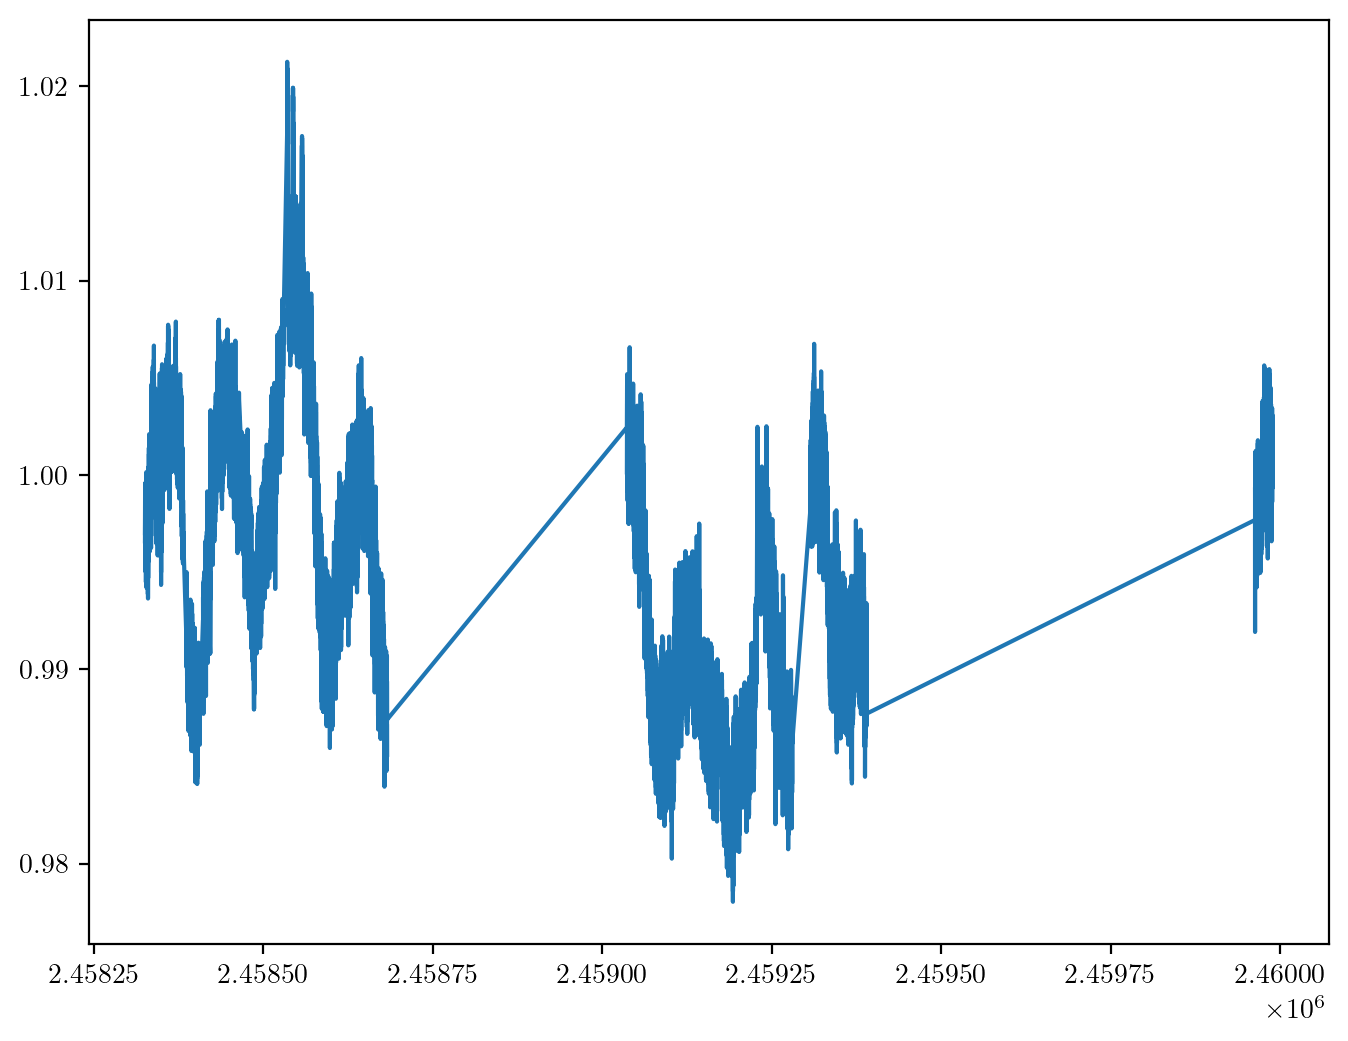

In [381]:
plt.plot(np.concatenate(tt)[np.concatenate(outlier_masks)], np.concatenate(ff_stitched)[np.concatenate(outlier_masks)])
plt.show()

In [383]:
np.save(f"TIC{TIC}", {
    'ID': TIC, 'f': pg.frequency.value,
    'p': pg.power.value,
    'Δν': seis.deltanu.value,
    'νmax': seis.numax.value,
    't': tt,
    'flux': ff,
    'flux_err': ee,
    'flux_norm': ff_stitched,
    'flux_err_norm': ee_stitched,
    'outlier_masks': outlier_masks
})

In [358]:
from astropy.timeseries import LombScargle

tpf_lc = lk.LightCurve(time=np.concatenate(tt)[np.concatenate(outlier_masks)] * u.d,
                       flux=np.concatenate(ff_stitched)[np.concatenate(outlier_masks)],
                       flux_err=np.concatenate(ee_stitched)[np.concatenate(outlier_masks)])
pg = tpf_lc.to_periodogram(normalization='psd', oversample_factor=1, maximum_frequency=(15 * u.uHz))